# Aplicación 1: Generación de texto mediante arquitecturas de tipo GPT

GPT (Generative Pre-trained Transformer) es un modelo de lenguaje desarrollado por OpenAI que se basa en una arquitectura de redes neuronales llamada Transformer. Se ha utilizado para tareas de procesamiento del lenguaje natural, como generación de texto, traducción, comprensión del lenguaje y más.

La arquitectura GPT se destaca por su **capacidad para aprender patrones complejos en conjuntos de datos masivos y generar texto coherente y relevante**.

Esta arquitectura se basa en la idea de **pre-entrenar un modelo en grandes cantidades de datos textuales para aprender representaciones del lenguaje**, y luego afinar o adaptar ese modelo a tareas específicas mediante un proceso llamado ajuste fino.

El modelo GPT utiliza Transformers para capturar relaciones y patrones a lo largo de secuencias de texto extensas. Como ya sabéis, los Transformers disponen de mecanismos de atención, lo que les permite asignar diferentes pesos a diferentes partes del texto de entrada, enfocándose en las partes relevantes para la tarea en cuestión.

**ChatGPT**

Como posiblemente hayáis comprobado todos ya, ChatGPT está diseñado para interactuar de manera conversacional. Ha sido entrenada con una gran cantidad de datos de texto, permitiéndole generar respuestas relevantes y coherentes en conversaciones humanas. Su estructura y funcionamiento se asemejan a un modelo de lenguaje, pero con la capacidad adicional de mantener y seguir una conversación a lo largo del tiempo.


**Aplicación 1: Generación de texto**

En este *notebook* veremos cómo se implementa un modelo GPT (artículo científico [aquí](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)), base fundamental de ChatGPT.

Veremos dos versiones:

- minGPT (más sencilla y educacional)
- nanoGPT (más compleja y competitiva)

Pero antes de eso, vamos a recordar cómo funcionan los *Transformers*, más concretamente, los modelos GPT. Para ello, seguiremos el maravilloso post de Jay Alammar:

http://jalammar.github.io/illustrated-gpt2/


## minGPT

`minGPT` es la versión más sencilla y educacional que os vais a encontrar de un modelo GPT. Básicamente dispone de **dos** archivos fundamentales:

- `model.py`: definición del modelo.
- `trainer.py`: *training loop* .

Veamos el fichero `trainer.py`:


In [ ]:
"""
Simple training loop; Boilerplate that could apply to any arbitrary neural network,
so nothing in this file really has anything to do with GPT specifically.
"""

import time
from collections import defaultdict

import torch
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import CfgNode as CN

class Trainer:

    @staticmethod
    def get_default_config():
        C = CN()
        # device to train on
        C.device = 'auto'
        # dataloder parameters
        C.num_workers = 4
        # optimizer parameters
        C.max_iters = None
        C.batch_size = 64
        C.learning_rate = 3e-4
        C.betas = (0.9, 0.95)
        C.weight_decay = 0.1 # only applied on matmul weights
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.callbacks = defaultdict(list)

        # determine the device we'll train on
        if config.device == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = config.device
        self.model = self.model.to(self.device)
        print("running on device", self.device)

        # variables that will be assigned to trainer class later for logging and etc
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def add_callback(self, onevent: str, callback):
        self.callbacks[onevent].append(callback)

    def set_callback(self, onevent: str, callback):
        self.callbacks[onevent] = [callback]

    def trigger_callbacks(self, onevent: str):
        for callback in self.callbacks.get(onevent, []):
            callback(self)

    def run(self):
        model, config = self.model, self.config

        # setup the optimizer
        self.optimizer = model.configure_optimizers(config)

        # setup the dataloader
        train_loader = DataLoader(
            self.train_dataset,
            sampler=torch.utils.data.RandomSampler(self.train_dataset, replacement=True, num_samples=int(1e10)),
            shuffle=False,
            pin_memory=True,
            batch_size=config.batch_size,
            num_workers=config.num_workers,
        )

        model.train()
        self.iter_num = 0
        self.iter_time = time.time()
        data_iter = iter(train_loader)
        while True:

            # fetch the next batch (x, y) and re-init iterator if needed
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                batch = next(data_iter)
            batch = [t.to(self.device) for t in batch]
            x, y = batch

            # forward the model
            logits, self.loss = model(x, y)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            self.loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            self.optimizer.step()

            self.trigger_callbacks('on_batch_end')
            self.iter_num += 1
            tnow = time.time()
            self.iter_dt = tnow - self.iter_time
            self.iter_time = tnow

            # termination conditions
            if config.max_iters is not None and self.iter_num >= config.max_iters:
                break

Como podéis comprobar, es muy sencillo.

Veamos ahora el `model.py`. En él, se definirán las siguientes clases, todas como tipo `nn.Module` para poder aprovechar el *autograd* de Pytorch. Por tanto, todas ellas tendrán como mínimo un método `forward` que especificará las operaciones a realizar.

- `NewGELU`: la función de activación empleada por la mayoría de *transformers*.
- `CausalSelfAttention`: el bloque que implementa la *auto-atención*.
- `Block`: implementa el bloque *decoder* de la arquitectura *transformer (ver ilustración más abajo).
- `GPT`: implementa el modelo GPT completo. Contiene más funciones útiles para la creación e inicialización del modelo, su entrenamiento y la generación de texto.


### Arquitectura del **decoder block** con el mecanismo de **causal self-attention** (**masked self-attention**)

__*Decoder block*__

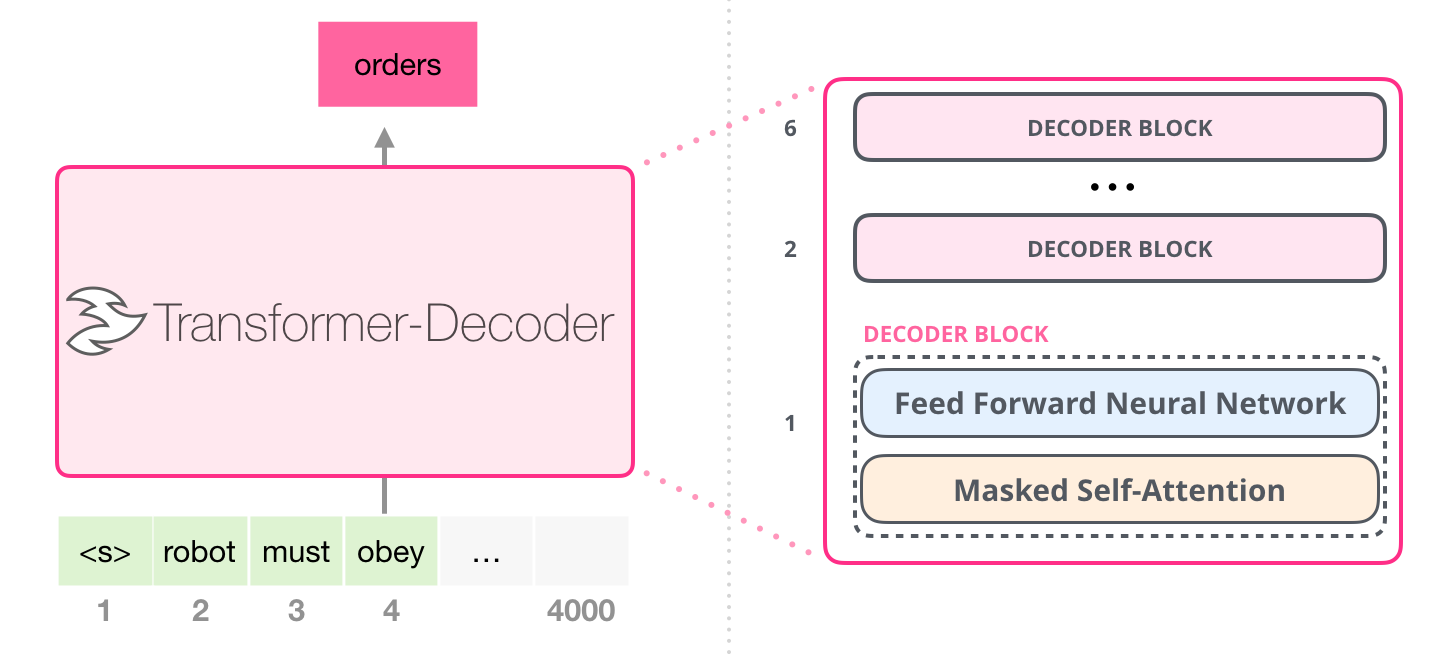


_**Causal self-attention**_

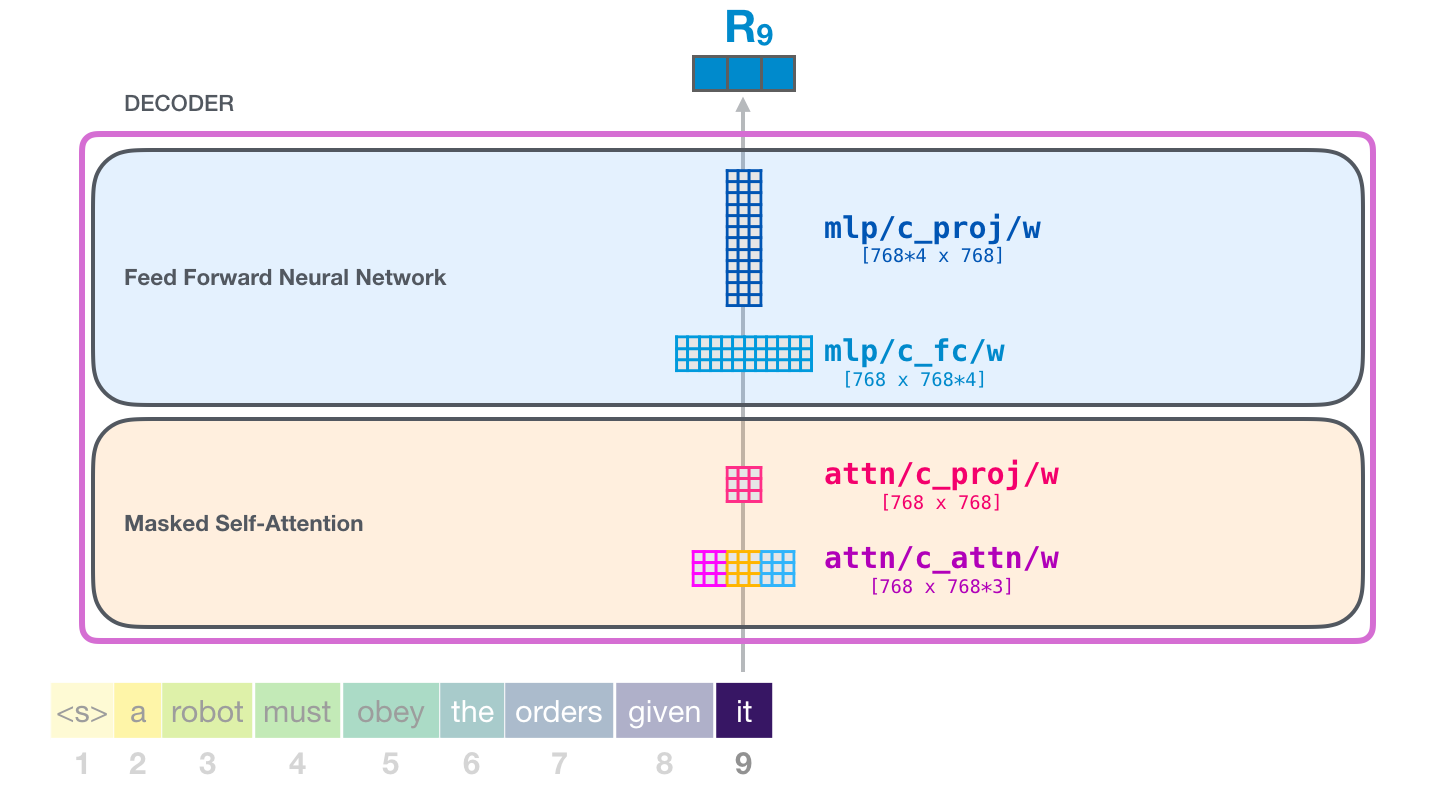

Y, por fin, el código:

In [ ]:
"""
Full definition of a GPT Language Model, all of it in this single file.

References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import math

import torch
import torch.nn as nn
from torch.nn import functional as F

from mingpt.utils import CfgNode as CN

# -----------------------------------------------------------------------------

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x)))) # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class GPT(nn.Module):
    """ GPT Language Model """

    @staticmethod
    def get_default_config():
        C = CN()
        # either model_type or (n_layer, n_head, n_embd) must be given in the config
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd =  None
        # these options must be filled in externally
        C.vocab_size = None
        C.block_size = None
        # dropout hyperparameters
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        return C

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size

        type_given = config.model_type is not None
        params_given = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        assert type_given ^ params_given # exactly one of these (XOR)
        if type_given:
            # translate from model_type to detailed configuration
            config.merge_from_dict({
                # names follow the huggingface naming conventions
                # GPT-1
                'openai-gpt':   dict(n_layer=12, n_head=12, n_embd=768),  # 117M params
                # GPT-2 configs
                'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
                'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
                'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
                'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
                # Gophers
                'gopher-44m':   dict(n_layer=8, n_head=16, n_embd=512),
                # (there are a number more...)
                # I made these tiny models up
                'gpt-mini':     dict(n_layer=6, n_head=6, n_embd=192),
                'gpt-micro':    dict(n_layer=4, n_head=4, n_embd=128),
                'gpt-nano':     dict(n_layer=3, n_head=3, n_embd=48),
            }[config.model_type])

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.embd_pdrop),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params/1e6,))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    @classmethod
    def from_pretrained(cls, model_type):
        """
        Initialize a pretrained GPT model by copying over the weights
        from a huggingface/transformers checkpoint.
        """
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel

        # create a from-scratch initialized minGPT model
        config = cls.get_default_config()
        config.model_type = model_type
        config.vocab_size = 50257 # openai's model vocabulary
        config.block_size = 1024  # openai's model block_size
        model = GPT(config)
        sd = model.state_dict()

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        keys = [k for k in sd_hf if not k.endswith('attn.masked_bias')] # ignore these
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla nn.Linear.
        # this means that we have to transpose these weights when we import them
        assert len(keys) == len(sd)
        for k in keys:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

Como podéis observar

Para ejecutar el código es mejor emplear el repositorio de GitHub donde está definido:

In [ ]:
!git clone https://github.com/karpathy/minGPT

Cloning into 'minGPT'...
remote: Enumerating objects: 489, done.
remote: Total 489 (delta 0), reused 0 (delta 0), pack-reused 489
Receiving objects: 100% (489/489), 1.44 MiB | 21.67 MiB/s, done.
Resolving deltas: 100% (261/261), done.


In [ ]:
%cd minGPT

/content/minGPT/minGPT


In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import set_seed
set_seed(3407)

Ahora crearemos un dataset sencillo que nos permitirá entrenar al modelo para que aprenda a ordenar secuencias de números entre el 0 y el 2:

In [ ]:
import pickle

class SortDataset(Dataset):
    """
    Dataset for the Sort problem. E.g. for problem length 6:
    Input: 0 0 2 1 0 1 -> Output: 0 0 0 1 1 2
    Which will feed into the transformer concatenated as:
    input:  0 0 2 1 0 1 0 0 0 1 1
    output: I I I I I 0 0 0 1 1 2
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=6, num_digits=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.num_digits = num_digits

    def __len__(self):
        return 10000 # ...

    def get_vocab_size(self):
        return self.num_digits

    def get_block_size(self):
        # the length of the sequence that will feed into transformer,
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * 2 - 1

    def __getitem__(self, idx):

        # use rejection sampling to generate an input example from the desired split
        while True:
            # generate some random integers
            inp = torch.randint(self.num_digits, size=(self.length,), dtype=torch.long)
            # half of the time let's try to boost the number of examples that
            # have a large number of repeats, as this is what the model seems to struggle
            # with later in training, and they are kind of rate
            if torch.rand(1).item() < 0.5:
                if inp.unique().nelement() > self.length // 2:
                    # too many unqiue digits, re-sample
                    continue
            # figure out if this generated example is train or test based on its hash
            h = hash(pickle.dumps(inp.tolist()))
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok

        # solve the task: i.e. sort
        sol = torch.sort(inp)[0]

        # concatenate the problem specification and the solution
        cat = torch.cat((inp, sol), dim=0)

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:self.length-1] = -1
        return x, y

Creamos los datasets y comprobamos que todo es correcto.

Pensemos que tenemos una entrada de 6 dígitos:

`Input: 0 0 2 1 0 1`

Y queremos que `minGPT` nos las ordene:

`Output: 0 0 0 1 1 2`

Para entrenar el modelo necesitamos alimentar al modelo con, primero la secuencia a ordenar, y luego las predicciones que debería ir haciendo en caso correcto (*labels*):

`input: 0 0 2 1 0 1 0 0 0 1 1`

`output: I I I I I 0 0 0 1 1 2`

Donde I es "ignore" (que codificaremos como `-1`), ya que esas son las muestras que le introducimos y queremos que el *transformer* lea antes de comenzar con la ordenación.

In [ ]:
# print an example instance of the dataset
train_dataset = SortDataset('train')
test_dataset = SortDataset('test')
x, y = train_dataset[0]
for a, b in zip(x,y):
    print(int(a),int(b))

2 -1
2 -1
0 -1
0 -1
1 -1
2 0
0 0
0 1
1 2
2 2
2 2


Ahora creamos el modelo `GPT`, en este caso seguirá la arquitectura `gpt-nano` de acuerdo a lo definido por HuggingFace.

In [ ]:
# create a GPT instance
from mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

number of parameters: 0.09M


Seguidamente creamos el `trainer` para entrenar al modelo:

In [ ]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 2000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_dataset)

running on device cuda


Y finalmente lo entrenamos:

In [ ]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()


iter_dt 0.00ms; iter 0: train loss 1.07777
iter_dt 12.44ms; iter 100: train loss 0.17031
iter_dt 13.25ms; iter 200: train loss 0.08092
iter_dt 12.40ms; iter 300: train loss 0.04176
iter_dt 13.73ms; iter 400: train loss 0.05298
iter_dt 20.93ms; iter 500: train loss 0.01619
iter_dt 19.25ms; iter 600: train loss 0.00690
iter_dt 12.77ms; iter 700: train loss 0.01664
iter_dt 18.72ms; iter 800: train loss 0.00525
iter_dt 13.06ms; iter 900: train loss 0.00068
iter_dt 12.69ms; iter 1000: train loss 0.00935
iter_dt 21.56ms; iter 1100: train loss 0.00603
iter_dt 14.42ms; iter 1200: train loss 0.00184
iter_dt 21.02ms; iter 1300: train loss 0.00589
iter_dt 12.51ms; iter 1400: train loss 0.02247
iter_dt 14.38ms; iter 1500: train loss 0.01172
iter_dt 16.78ms; iter 1600: train loss 0.01978
iter_dt 18.21ms; iter 1700: train loss 0.02650
iter_dt 12.76ms; iter 1800: train loss 0.00147
iter_dt 12.09ms; iter 1900: train loss 0.00483


Ahora podemos evaluarlo:

In [ ]:
# now let's perform some evaluation
model.eval();

In [ ]:
def eval_split(trainer, split, max_batches):
    dataset = {'train':train_dataset, 'test':test_dataset}[split]
    n = train_dataset.length # naugy direct access shrug
    results = []
    mistakes_printed_already = 0
    loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        y = y.to(trainer.device)
        # isolate the input pattern alone
        inp = x[:, :n]
        sol = y[:, -n:]
        # let the model sample the rest of the sequence
        cat = model.generate(inp, n, do_sample=False) # using greedy argmax, not sampling
        sol_candidate = cat[:, n:] # isolate the filled in sequence
        # compare the predicted sequence to the true sequence
        correct = (sol == sol_candidate).all(1).cpu() # Software 1.0 vs. Software 2.0 fight RIGHT on this line haha
        for i in range(x.size(0)):
            results.append(int(correct[i]))
            if not correct[i] and mistakes_printed_already < 3: # only print up to 5 mistakes to get a sense
                mistakes_printed_already += 1
                print("GPT claims that %s sorted is %s but gt is %s" % (inp[i].tolist(), sol_candidate[i].tolist(), sol[i].tolist()))
        if max_batches is not None and b+1 >= max_batches:
            break
    rt = torch.tensor(results, dtype=torch.float)
    print("%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))
    return rt.sum()

# run a lot of examples from both train and test through the model and verify the output correctness
with torch.no_grad():
    train_score = eval_split(trainer, 'train', max_batches=50)
    test_score  = eval_split(trainer, 'test',  max_batches=50)

train final score: 5000/5000 = 100.00% correct
test final score: 5000/5000 = 100.00% correct


In [ ]:
# let's run a random given sequence through the model as well
n = train_dataset.length # naugy direct access shrug
inp = torch.tensor([[0, 0, 2, 1, 0, 1]], dtype=torch.long).to(trainer.device)
assert inp[0].nelement() == n
with torch.no_grad():
    cat = model.generate(inp, n, do_sample=False)
sol = torch.sort(inp[0])[0]
sol_candidate = cat[:, n:]
print('input sequence  :', inp.tolist())
print('predicted sorted:', sol_candidate.tolist())
print('gt sort         :', sol.tolist())
print('matches         :', bool((sol == sol_candidate).all()))

input sequence  : [[0, 0, 2, 1, 0, 1]]
predicted sorted: [[0, 0, 0, 1, 1, 2]]
gt sort         : [0, 0, 0, 1, 1, 2]
matches         : True


## nanoGPT

Esta versión es más compleja y a su vez más potente. Contiene más funciones y el código no es tan educativo. La incluimos para permitir su uso en problemas más complejos.

Lo que haremos será emplear la arquitectura `gpt2` y re-entrenarla en un dataset de *Shakespeare*.

Vamos allá:

In [ ]:
!git clone https://github.com/karpathy/nanoGPT

Cloning into 'nanoGPT'...
remote: Enumerating objects: 649, done.
remote: Total 649 (delta 0), reused 0 (delta 0), pack-reused 649
Receiving objects: 100% (649/649), 936.46 KiB | 17.67 MiB/s, done.
Resolving deltas: 100% (371/371), done.


In [ ]:
# gpt2 uses transformers
!pip install openai cohere
!pip install tiktoken transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.8/220.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires tiktoken, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 15.0 MB/s eta 0:00:00


Preparamos el dataset:

In [ ]:
!cd ./nanoGPT/data/shakespeare/ && python prepare.py

train has 301,966 tokens
val has 36,059 tokens


Y entrenamos:

In [ ]:
!cd ./nanoGPT/ && python train.py --dtype=float16 --dataset=shakespeare --compile=False --n_layer=4 --n_head=4 --n_embd=64 --block_size=64 --batch_size=8 --init_from=gpt2 --eval_interval=100 --eval_iters=100 --max_iters=300 --bias=True

Overriding: dtype = float16
Overriding: dataset = shakespeare
Overriding: compile = False
Overriding: n_layer = 4
Overriding: n_head = 4
Overriding: n_embd = 64
Overriding: block_size = 64
Overriding: batch_size = 8
Overriding: init_from = gpt2
Overriding: eval_interval = 100
Overriding: eval_iters = 100
Overriding: max_iters = 300
Overriding: bias = True
tokens per iteration will be: 20,480
Initializing from OpenAI GPT-2 weights: gpt2
loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
config.json: 100% 665/665 [00:00<00:00, 2.81MB/s]
model.safetensors: 100% 548M/548M [00:01<00:00, 284MB/s]
generation_config.json: 100% 124/124 [00:00<00:00, 585kB/s]
num decayed parameter tensors: 50, with 123,581,184 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
step 0: train loss 4.9517, val loss 4.8356
iter 0: loss 4.8551, time 5672.68ms, mfu -10

Ahora podemos comenzar a hacer pruebas:

In [ ]:
!cd ./nanoGPT && python sample.py --dtype=float16 --num_samples=5 --max_new_tokens=10 --start="to be"

Overriding: dtype = float16
Overriding: num_samples = 5
Overriding: max_new_tokens = 10
Overriding: start = to be
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...
to be more fair, so
I will have it be
---------------
to be made so?

DUKE VINC
---------------
to be,
For my part, and not under the
---------------
to be an officer, a brother, an errand-
---------------
to be a pretty woman for that.

POLIX
---------------


In [ ]:
!cd ./nanoGPT && python sample.py --dtype=float16 --num_samples=5 --max_new_tokens=10 --start="the happiness"

Overriding: dtype = float16
Overriding: num_samples = 5
Overriding: max_new_tokens = 10
Overriding: start = the happiness
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...
the happiness of any; therefore, let him have
all
---------------
the happiness of so doing
And that no man shall prosper
---------------
the happiness of the soul.
The world is full of
---------------
the happiness of this court,
Now an errand to
---------------
the happiness and sovereignty of that land
That shapes the life
---------------


In [ ]:
!cd ./nanoGPT && python sample.py --dtype=float16 --num_samples=5 --max_new_tokens=50 --start="the sadness"

Overriding: dtype = float16
Overriding: num_samples = 5
Overriding: max_new_tokens = 50
Overriding: start = the sadness
number of parameters: 123.65M
No meta.pkl found, assuming GPT-2 encodings...
the sadness of death,--
I will have nothing but this slaughter: I want it no less.
The wattle and the sparrow are here,--I'll kill them all; they are gone;
I'll be their butcher: the life
---------------
the sadness of his mouth,
And the sourness of his brow, hath made my heart
Furrow to tears, and sometimes I moan
When I breathe a word. I hope you are well received,
And thrive well on your good name
---------------
the sadness of death,
Whose hand I lack not to endure it;
For more wounds to be endured than injuries to die
Are buried in this world.

CLARENCE:
I crave some means to do it.

D
---------------
the sadness, the sorrow,
Whose dear thoughts see no sorrow; and in
Our sorrows there is nothing but sorrow,
That we may have death, and in death we die.
Let me be the cause of thy sorrow;
A

## Más recursos:

- **Teoría y práctica**
- https://github.com/jaydeepthik/Nano-GPT
- http://jalammar.github.io/illustrated-gpt2/
- https://bea.stollnitz.com/blog/how-gpt-works-technical/

- **Ejemplos interactivos**

- https://demo.allennlp.org/next-token-lm
- https://demo.allennlp.org/masked-lm